# Read the File


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.master("local[*]").appName("nyc").getOrCreate()

df = spark.read.option("header", True).csv("nyc-jobs.csv")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/18 00:22:08 WARN Utils: Your hostname, Earams-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.29.11 instead (on interface en0)
26/02/18 00:22:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/18 00:22:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Calculate average salary

In [4]:
df = df.withColumn("salary_from", col("Salary Range From").cast("double")) \
       .withColumn("salary_to", col("Salary Range To").cast("double"))

df = df.withColumn("avg_salary", (col("salary_from") + col("salary_to")) / 2)


# Whats the number of jobs posting per category (Top 10)?

In [2]:
df.groupBy("Job Category").count().orderBy(desc("count")).limit(10).show()


+--------------------+-----+
|        Job Category|count|
+--------------------+-----+
|Engineering, Arch...|  504|
|Technology, Data ...|  313|
|       Legal Affairs|  226|
|Public Safety, In...|  182|
|Building Operatio...|  181|
|Finance, Accounti...|  169|
|Administration & ...|  134|
|Constituent Servi...|  129|
|              Health|  125|
|Policy, Research ...|  124|
+--------------------+-----+



# Whats the salary distribution per job category?


In [5]:
df.groupBy("Job Category").agg(
    avg("avg_salary").alias("avg_salary"),
    max("avg_salary").alias("max_salary")
).show()


+--------------------+------------------+----------+
|        Job Category|        avg_salary|max_salary|
+--------------------+------------------+----------+
|Information Techn...|           76941.5|   76941.5|
|Legal Affairs Pol...| 88898.66666666667|  115732.0|
|Constituent Servi...| 57877.57780387596|  135000.0|
|Building Operatio...| 37597.39734033149|  169011.0|
|       Legal Affairs| 83247.09196106195|  191913.0|
|Maintenance & Ope...|          42995.45|   65458.8|
|                NULL|           82661.0|  111377.0|
|Clerical & Admini...|         48345.625|   50333.0|
|Engineering, Arch...|          198518.0|  198518.0|
|Administration & ...| 91174.22222222222|  177374.5|
|              Health|58466.322832399994| 170133.84|
|Administration & ...| 46386.26363636364|   86419.5|
|Engineering, Arch...| 89857.43548387097|  134866.5|
|Clerical & Admini...| 36432.23923076923|   52817.5|
|Engineering, Arch...| 88213.69354838709|  134866.5|
|Administration & ...|           47864.5|   47

# Is there any correlation between the higher degree and the salary?


In [6]:
df = df.withColumn(
    "has_degree",
    when(lower(col("Minimum Qual Requirements")).contains("degree"),1).otherwise(0)
)

df.select("has_degree","avg_salary").na.drop().stat.corr("has_degree","avg_salary")


0.25892550441387424

# Whats the job posting having the highest salary per agency?

In [7]:
df.groupBy("Agency").agg(max("avg_salary").alias("highest_salary")).show()


+--------------------+--------------+
|              Agency|highest_salary|
+--------------------+--------------+
|OFFICE OF COLLECT...|         9.555|
|ADMIN FOR CHILDRE...|      117474.5|
|MANHATTAN COMMUNI...|          19.0|
|TAXI & LIMOUSINE ...|      140000.0|
|DEPARTMENT OF BUS...|      111377.0|
|DEPT OF DESIGN & ...|      151795.0|
|FINANCIAL INFO SV...|      135000.0|
|HOUSING PRESERVAT...|      135000.0|
|CIVILIAN COMPLAIN...|      115732.0|
|OFFICE OF MANAGEM...|      117810.0|
|DEPARTMENT OF CIT...|      125000.0|
|DEPT OF HEALTH/ME...|     170133.84|
| BOARD OF CORRECTION|       96222.5|
|   POLICE DEPARTMENT|      217201.0|
|BUSINESS INTEGRIT...|       95000.0|
|DEPARTMENT OF TRA...|      108042.0|
|NYC EMPLOYEES RET...|      177374.5|
|      LAW DEPARTMENT|      164104.0|
|DEPT OF INFO TECH...|      138968.0|
|OFFICE OF THE COM...|      167500.0|
+--------------------+--------------+
only showing top 20 rows


In [3]:
df = df.withColumn(
    "posting_year",
    regexp_extract(col("Posting Date"), r'(\d{4})', 1).cast("int")
)


In [4]:
df = df.withColumn(
    "has_degree",
    when(lower(col("Minimum Qual Requirements")).contains("degree"),1).otherwise(0)
)


In [8]:
from pyspark.sql.functions import regexp_extract, when, length, col

df = df.withColumn(
    "posting_year_raw",
    regexp_extract(col("Posting Date"), r'(\d{4})', 1)
)

df = df.withColumn(
    "posting_year",
    when(length(col("posting_year_raw")) > 0, col("posting_year_raw").cast("int"))
    .otherwise(None)
)


In [9]:
df.show()

+------+--------------------+------------+--------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+----------+------------+----------+----------------+
|Job ID|              Agency|Posting Type|# Of Positions|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|      

In [10]:
recent = df.filter(col("posting_year") >= 2024)

recent.groupBy("Agency") \
      .agg(avg("avg_salary").alias("avg_salary_last_2yrs")) \
      .show()


+--------------------+--------------------+
|              Agency|avg_salary_last_2yrs|
+--------------------+--------------------+
|DEPT OF HEALTH/ME...|            74968.25|
|DEPT OF DESIGN & ...|             80526.5|
|CIVILIAN COMPLAIN...|             27.1355|
|DEPT OF ENVIRONME...|             89349.0|
|DEPT OF CITYWIDE ...|             78804.5|
|DEPARTMENT OF TRA...|            61358.25|
|DEPT OF INFO TECH...|            117470.0|
|DEPT OF YOUTH & C...|             54744.0|
|DEPARTMENT OF INV...|             63024.5|
|LANDMARKS PRESERV...|             60103.5|
|   POLICE DEPARTMENT|             54402.0|
+--------------------+--------------------+



In [12]:
skills_df = df.withColumn(
    "skill",
    explode(split(col("Preferred Skills"), ","))
)

skills_df = skills_df.withColumn("skill", trim(lower(col("skill"))))

top_skills = skills_df.groupBy("skill").agg(avg("avg_salary").alias("avg_salary")).orderBy(desc("avg_salary")).limit(10)

top_skills.show()

+--------------------+----------+
|               skill|avg_salary|
+--------------------+----------+
|he/she must be an...|  218587.0|
|and implement act...|  218587.0|
|   diagnose problems|  218587.0|
|and implementing ...|  218587.0|
|of which at least...|  218587.0|
|the following ski...|  218587.0|
|develop and retai...|  218587.0|
|city and state go...|  218587.0|
|continuous improv...|  218587.0|
|communication and...|  218587.0|
+--------------------+----------+



In [19]:
from pyspark.sql.functions import col, when, lower, regexp_extract

def clean_salary(df):
    df = df.withColumn("salary_from", col("Salary Range From").cast("double")) \
           .withColumn("salary_to", col("Salary Range To").cast("double"))
    df= df.withColumn("avg_salary", (col("salary_from") + col("salary_to")) / 2)
    
    return df

def extract_posting_year(df):
    df = df.withColumn("posting_year_raw",
                       regexp_extract(col("Posting Date"), r'(\d{4})', 1))
    df= df.withColumn(
        "posting_year",
        when(col("posting_year_raw") != "", col("posting_year_raw").cast("int"))
        .otherwise(None)
    )
    return df
    

def add_degree_flag(df):
    df=df.withColumn(
        "has_degree",
        when(lower(col("Minimum Qual Requirements")).contains("degree"),1).otherwise(0)
    )
    return df
    


In [8]:
df = df.withColumn(
    "salary_bucket",
    when(col("avg_salary") >= 100000, "High")
    .when(col("avg_salary") >= 50000, "Medium")
    .otherwise("Low")
).show()


+------+--------------------+------------+--------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+----------+----------+-------------+
|Job ID|              Agency|Posting Type|# Of Positions|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|         Hours/Shift| 

In [22]:
df = df.drop("Job Description")


In [23]:
df.write.mode("overwrite").csv("processed_jobs")


In [ ]:
def get_salary_frequency(df: DataFrame) -> list:
    row_list = df.select('Salary Frequency').distinct().collect()
    return [row['Salary Frequency'] for row in row_list]

In [ ]:
def test_get_salary_frequency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['id', 'Salary Frequency']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert get_salary_frequency(mock_df) == expected_result

In [48]:
assert df.filter(col("avg_salary").isNull()).count() == 0


ConnectionRefusedError: [Errno 61] Connection refused

In [13]:
pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 4.0 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 3.8 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]2m1/2 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 3.9 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 3.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 3.9 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [2]:
pdf = df.groupBy("Job Category").count().orderBy(desc("count")).limit(10).toPandas()




Matplotlib is building the font cache; this may take a moment.


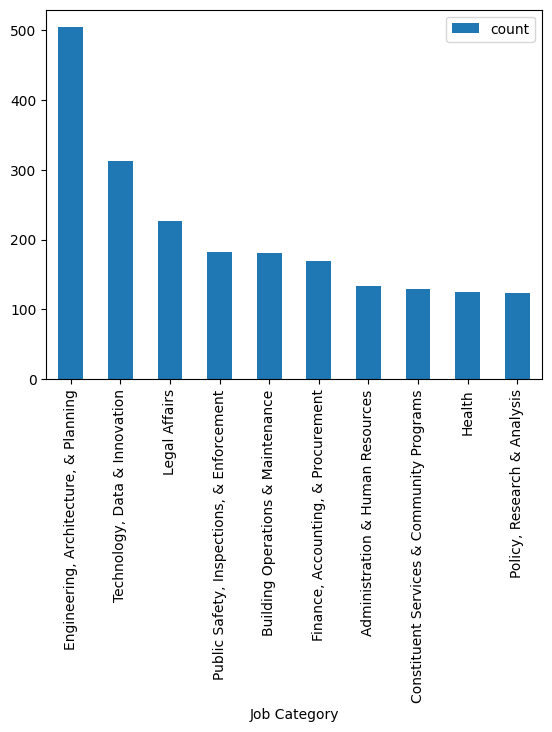

In [3]:
import matplotlib.pyplot as plt
pdf.plot(kind="bar", x="Job Category", y="count")
plt.show()